# SDR Codebook optimization

## Setup

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sionna.rt import Antenna

import project_path as pp
from cissir.physics import pow2db, db2power, mag2db

from cissir import params, optimization as opt
from cissir.beamforming import dft_codebook, plot_beamforming_polar
from cissir.utils import PrintBuffer

base_path = pp.module_path
plot_path = base_path/"plots"
res_path = base_path/"results"

In [2]:
# Global parameters

c = params.c
fc = params.fc_hz
wavelength_m = params.wavelength_m

ula_el_spacing = params.array_electrical_spacing

N_r = params.n_rx
N_t = params.n_tx

# Number of beams
L_r = params.num_beams
L_t = params.num_beams

### DFT beam codebook


In [3]:
dft_tx_codebook, tx_degs = dft_codebook(L_max = L_t , N1 = N_t,
                                          az_min = -60, az_max = 60, transmit=True)
dft_rx_codebook, rx_degs = dft_codebook(L_max = L_r , N1 = N_r,
                                          az_min = -60, az_max = 60, transmit=False)

In [4]:
si_num_taps = "full"    # Options: 1, 2, "full"

with np.load(res_path/"channel_impulse_responses.npz") as rt_data:
    t_rt = np.squeeze(rt_data['t_channel_s'])
    ht_si_full = np.squeeze(rt_data['ht_si'])
    h_full = np.sum(ht_si_full, axis=0).transpose(2, 0, 1)

if si_num_taps == "full":
        h_si = np.sum(ht_si_full, axis=0).transpose(2, 0, 1)
        si_pow_db = mag2db(np.max(opt.codebook_si(dft_tx_codebook, dft_rx_codebook, h_si)))
else:
    with np.load(res_path/"si_mimo.npz") as rt_data:
        h_si = rt_data['h_si_matrix'][:si_num_taps]

        h_cir = np.sum(ht_si_full[:si_num_taps,], axis=0).transpose(2, 0, 1)
        si_pow_db = mag2db(np.max(opt.codebook_si(dft_tx_codebook, dft_rx_codebook, h_cir)))
    
        assert h_si.shape == (si_num_taps, N_r, N_t), "Unexpected SI shape"


In [5]:
h_si_rx, h_si_tx = opt.si_split(h_si)

si_normalized_ref = mag2db(np.max(opt.codebook_si(dft_tx_codebook, dft_rx_codebook, h_si)))
si_norm_db = float(si_pow_db) - si_normalized_ref
si_db_ref = si_normalized_ref + si_norm_db


In [6]:
min_eigval_db = mag2db(opt.min_eigval(h_si))
max_eigval_db = mag2db(opt.max_eigval(h_si))

min_split_db = pow2db(opt.min_eigval(h_si_rx)*opt.min_eigval(h_si_tx))
max_split_db = pow2db(opt.max_eigval(h_si_rx)*opt.max_eigval(h_si_tx))

In [7]:
print(f"      eig_min H: {min_eigval_db+si_norm_db:.1f} dB")
print(f"eig_min Grx\Gtx: {min_split_db+si_norm_db:.1f} dB")
print(f"            cHw: {si_db_ref:.1f} dB")
print(f"      eig_max H: {max_eigval_db+si_norm_db:.1f} dB")
print(f"eig_max Grx\Gtx: {max_split_db+si_norm_db:.1f} dB")

      eig_min H: -286.8 dB
eig_min Grx\Gtx: -147.6 dB
            cHw: -67.5 dB
      eig_max H: -59.7 dB
eig_max Grx\Gtx: -40.4 dB


## Optimization

In [8]:
extra_attenuations = np.arange(-1, 70, 1)
feasible_tolerance = 1e-2
pbuf = PrintBuffer(print_input=False)

In [9]:
debug_collector = []
results = []
codebooks = []

phased_array = True
sdrCodebooks = opt.SDRcodebook(h_si, dft_tx_codebook, dft_rx_codebook,
                               si_threshold_power=1.0, beta=0.5, phased=phased_array)
gram_beams_tx = sdrCodebooks.gram_codebook(dft_tx_codebook)
gram_beams_rx = sdrCodebooks.gram_codebook(dft_rx_codebook)


pbar = tqdm(extra_attenuations)
pbar.set_description(f"Baseline SI {si_db_ref:.1f} dB")
for extra_att_db in pbar:
    
    gain_norm_db = si_normalized_ref - extra_att_db 
    att_db = -(si_norm_db + gain_norm_db)

    tgt_si_pow = db2power(gain_norm_db)
    sdrCodebooks.si_threshold_power = tgt_si_pow
        
    pbuf.print(f"SI-ATT. {att_db:.1f} dB")

    try:
        start_time = time.perf_counter()
        w_codebook, W_sol = sdrCodebooks.solve(tx=True, return_sdr=True)
        c_codebook, C_sol = sdrCodebooks.solve(tx=False, return_sdr=True)
        end_time = time.perf_counter()
    except opt.la.LinAlgError:
        print("Breaking loop due to convergence issues")
        pbar.close()
        break

    si_db_sdr = mag2db(opt.sdr_si(W_sol, C_sol, h_si).max())
    loss_w_sdr = pow2db(max(opt.sdr_codebook_deviation(W_sol, gram_beams_tx), 1e-10))
    loss_c_sdr = pow2db(max(opt.sdr_codebook_deviation(C_sol, gram_beams_rx), 1e-10))
    
    max_c_err = opt.maxSdrError(C_sol, c_codebook)
    max_w_err = opt.maxSdrError(W_sol, w_codebook)
    max_amp_err = np.sqrt(max(max_c_err, max_w_err))
    
    si_db_rank1 = mag2db(np.max(opt.codebook_si(w_codebook, c_codebook, h_si)))
    loss_w_rank1 = pow2db(max(opt.codebook_deviation_power(dft_tx_codebook, w_codebook), 1e-10))
    loss_c_rank1 = pow2db(max(opt.codebook_deviation_power(dft_rx_codebook, c_codebook), 1e-10))
    
    att_sdr = -(si_norm_db+si_db_sdr)
    att_rank1 = -(si_norm_db+si_db_rank1)

    pbuf.print("Solutions SDR\\Rank-1:")
    pbuf.print(f"\t\tSI att.:\t{att_sdr:.1f}\\{att_rank1:.1f} dB\t({si_normalized_ref-si_db_rank1:.1f} dB from baseline)")
    pbuf.print(f"\t\tTx error:\t{loss_w_sdr:.1f}\\{loss_w_rank1:.1f} dB")
    pbuf.print(f"\t\tRx error:\t{loss_c_sdr:.1f}\\{loss_c_rank1:.1f} dB")
    pbuf.print(f"\tMax sol. error {max_amp_err:.2E}")
    
    postfix = (f"SI Tgt::Actual {att_db:.1f}::{att_rank1:.1f} dB; "
               f"Error Tx::Rx {loss_w_rank1:.1f}::{loss_c_rank1:.1f} dB; "
               f"Max sol. error {max_amp_err:.2E}")
    pbar.set_postfix_str(postfix)

    if si_num_taps == "full":
        att_full_db = att_rank1
    else:
        si_db_full = mag2db(np.max(opt.codebook_si(w_codebook, c_codebook, h_full)))
        att_full_db =  - si_db_full

    if max_amp_err < feasible_tolerance:
        codebooks.append({"att_tgt": att_db, "att_opt": att_rank1, "rx_codebook_p": c_codebook, "tx_codebook_p": w_codebook})
    else:
        att_rank1 = None
        att_full_db = None
        loss_w_rank1= None
        loss_c_rank1= None

    results.append({"att_tgt": att_db, "opt": "sdp", "rx_sdr_err": max_c_err, "tx_sdr_err": max_w_err,
                    "att_opt": att_rank1, "tx_loss": loss_w_rank1, "rx_loss": loss_c_rank1, "elapsed_time": end_time - start_time,
                    "att_sdr": att_sdr, "tx_loss_sdr": loss_w_sdr, "rx_loss_sdr": loss_c_sdr, "att_full": att_full_db,
                    "phased": phased_array, "si_taps": si_num_taps, "num_beams": L_t})


  0%|          | 0/71 [00:00<?, ?it/s]

Breaking loop due to convergence issues


In [10]:
pbuf.print()

SI-ATT. 66.5 dB
Solutions SDR\Rank-1:
		SI att.:	67.5\67.5 dB	(-0.0 dB from baseline)
		Tx error:	-75.6\-100.0 dB
		Rx error:	-75.7\-100.0 dB
	Max sol. error 2.43E-03
SI-ATT. 67.5 dB
Solutions SDR\Rank-1:
		SI att.:	67.5\67.5 dB	(0.0 dB from baseline)
		Tx error:	-65.0\-95.7 dB
		Rx error:	-61.1\-66.5 dB
	Max sol. error 2.99E-03
SI-ATT. 68.5 dB
Solutions SDR\Rank-1:
		SI att.:	68.5\68.5 dB	(1.0 dB from baseline)
		Tx error:	-41.3\-41.3 dB
		Rx error:	-42.0\-42.0 dB
	Max sol. error 2.38E-03
SI-ATT. 69.5 dB
Solutions SDR\Rank-1:
		SI att.:	69.5\69.5 dB	(2.0 dB from baseline)
		Tx error:	-34.7\-34.7 dB
		Rx error:	-35.2\-35.2 dB
	Max sol. error 2.77E-03
SI-ATT. 70.5 dB
Solutions SDR\Rank-1:
		SI att.:	70.5\70.5 dB	(3.0 dB from baseline)
		Tx error:	-31.1\-31.1 dB
		Rx error:	-31.5\-31.5 dB
	Max sol. error 2.31E-03
SI-ATT. 71.5 dB
Solutions SDR\Rank-1:
		SI att.:	71.5\71.5 dB	(4.0 dB from baseline)
		Tx error:	-28.7\-28.7 dB
		Rx error:	-29.0\-29.0 dB
	Max sol. error 2.74E-03
SI-ATT. 72.5 

## Saving results

In [11]:
res_file = res_path/f"sdp_cb_results_phased_{si_num_taps}tap_si.csv"
res_df = pd.DataFrame(results)
res_df.to_csv(res_file)
print(f"Results saved under {res_file}")

Results saved under /mnt/project/results/sdp_cb_results_phased_fulltap_si.csv


In [13]:
method = "sdp_ph_full"

att_values = [-np.inf]
att_achieved = [si_db_ref]
tx_codebooks = [dft_tx_codebook]
rx_codebooks = [dft_rx_codebook]
for cb in codebooks:
    att_values.append(cb["att_tgt"])
    att_achieved.append(cb["att_opt"])
    tx_codebooks.append(cb["tx_codebook_p"])
    rx_codebooks.append(cb["rx_codebook_p"])

att_values = np.array(att_values) 
tx_codebooks = np.stack(tx_codebooks, axis=0)
rx_codebooks = np.stack(rx_codebooks, axis=0)

metadata = np.array({"method": method, "phased": phased_array, "si_num_taps": si_num_taps,
                     "norm": "max"})
fname = f"{method}_codebooks.npz"
np.savez(res_path/fname, att_tgt=att_values,
         att_opt=att_achieved,
         rx_degrees=rx_degs, tx_degrees=tx_degs,
         rx=rx_codebooks, tx=tx_codebooks,
         metadata=metadata)
print(f"{fname} was saved at {res_path}.")

sdp_ph_full_codebooks.npz was saved at /mnt/project/results.


## Plot

In [14]:
plot_att = 100
att_index = np.argmin(np.abs(np.array(att_values) - plot_att))
att_db_val = att_values[att_index]
opt_tx_codebook = tx_codebooks[att_index,]
opt_rx_codebook = rx_codebooks[att_index,]

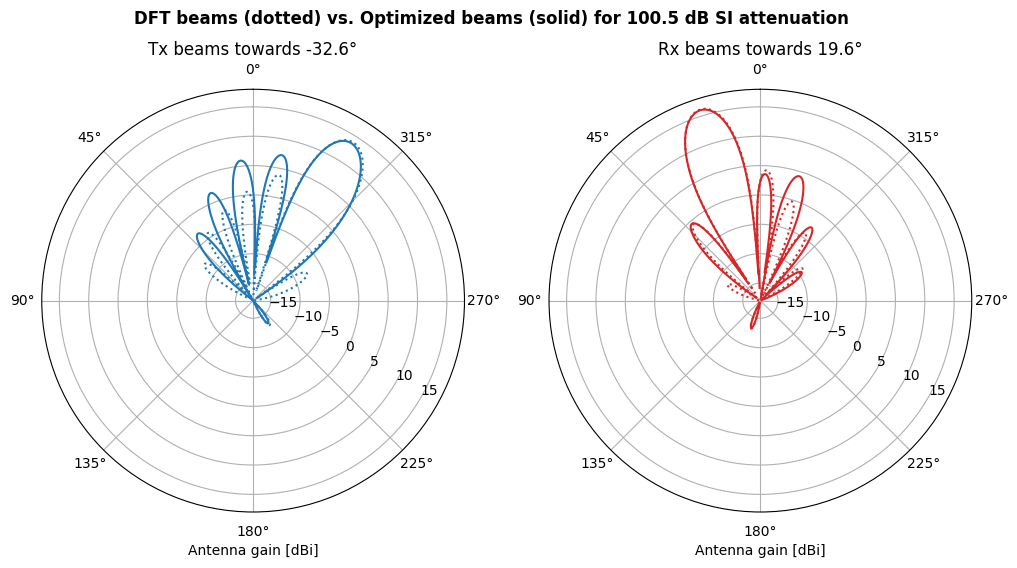

In [15]:
antenna_pattern = Antenna(params.antenna_pattern, polarization=params.antenna_polarization).patterns
rad_pattern = lambda x: sum(sum(np.abs(p)**2 for p in pat(np.pi/2, x)) for pat in antenna_pattern)

f, (ax_tx, ax_rx) = plt.subplots(1, 2, figsize=(12,6), subplot_kw={'projection': 'polar'})
tx_beam = 1
tx_kwargs = dict(transmit=True, element_pattern=rad_pattern, axis=ax_tx, r_lim=(-18, 18), color="tab:blue")
_ = plot_beamforming_polar(dft_tx_codebook[:, tx_beam:tx_beam+1], linestyle=":", **tx_kwargs)
_ = plot_beamforming_polar(opt_tx_codebook[:, tx_beam:tx_beam+1], **tx_kwargs)
_ = ax_tx.set_title(f"Tx beams towards {tx_degs[tx_beam]:.1f}°")

rx_beam = 5
rx_kwargs = dict(transmit=False, element_pattern=rad_pattern, axis=ax_rx, r_lim=(-18, 18), color="tab:red")
_ = plot_beamforming_polar(dft_rx_codebook[:, rx_beam:rx_beam+1], linestyle=":", **rx_kwargs)
_ = plot_beamforming_polar(opt_rx_codebook[:, rx_beam:rx_beam+1], **rx_kwargs)
_ = ax_rx.set_title(f"Rx beams towards {rx_degs[rx_beam]:.1f}°")

_ = plt.suptitle(f"DFT beams (dotted) vs. Optimized beams (solid) for {att_db_val:.1f} dB SI attenuation", weight="bold")